# 0. Import libraries

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset 

import tqdm
from torch.autograd import Variable
import argparse
import math
import torch.nn.functional as F
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

## 1. read datasets

In [130]:
df_kospi = pd.read_csv('./kospi.csv')
df_sec = pd.read_csv('./sec.csv')
df_gold = pd.read_csv('./gold.csv')
df_snp = pd.read_csv('./snp.csv')
df_crate = pd.read_csv('./usdkrw.csv')

In [131]:
print(df_kospi.tail())
print(df_sec.tail())
print(df_gold.tail())
print(df_snp.tail())
print(df_crate.tail())

            Date         Open         High          Low        Close  \
6742  2024-04-22  2615.719971  2629.439941  2604.370117  2629.439941   
6743  2024-04-23  2632.149902  2641.780029  2619.719971  2623.020020   
6744  2024-04-24  2662.840088  2677.850098  2662.840088  2675.750000   
6745  2024-04-25  2646.800049  2656.510010  2628.620117  2628.620117   
6746  2024-04-26  2650.939941  2655.840088  2641.350098  2654.820068   

        Adj Close  Volume  
6742  2629.439941  401900  
6743  2623.020020  430300  
6744  2675.750000  325100  
6745  2628.620117  334100  
6746  2654.820068  210079  
            Date     Open     High      Low    Close  Adj Close    Volume
6092  2024-04-22  77400.0  77500.0  75100.0  76100.0    76100.0  30469477
6093  2024-04-23  76400.0  76800.0  75500.0  75500.0    75500.0  18717699
6094  2024-04-24  77500.0  78800.0  77200.0  78600.0    78600.0  22166150
6095  2024-04-25  77300.0  77500.0  76300.0  76300.0    76300.0  15549134
6096  2024-04-26  77800.0  77

In [132]:
df_sec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6097 entries, 0 to 6096
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6097 non-null   object 
 1   Open       6097 non-null   float64
 2   High       6097 non-null   float64
 3   Low        6097 non-null   float64
 4   Close      6097 non-null   float64
 5   Adj Close  6097 non-null   float64
 6   Volume     6097 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 333.6+ KB


In [133]:
df_gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5935 entries, 0 to 5934
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5935 non-null   object 
 1   Open       5935 non-null   float64
 2   High       5935 non-null   float64
 3   Low        5935 non-null   float64
 4   Close      5935 non-null   float64
 5   Adj Close  5935 non-null   float64
 6   Volume     5935 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 324.7+ KB


In [134]:
df_kospi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6747 entries, 0 to 6746
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6747 non-null   object 
 1   Open       6747 non-null   float64
 2   High       6747 non-null   float64
 3   Low        6747 non-null   float64
 4   Close      6747 non-null   float64
 5   Adj Close  6747 non-null   float64
 6   Volume     6747 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 369.1+ KB


In [135]:
df_snp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24195 entries, 0 to 24194
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       24195 non-null  object 
 1   Open       24195 non-null  float64
 2   High       24195 non-null  float64
 3   Low        24195 non-null  float64
 4   Close      24195 non-null  float64
 5   Adj Close  24195 non-null  float64
 6   Volume     24195 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.3+ MB


In [136]:
df_crate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5293 entries, 0 to 5292
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5293 non-null   object 
 1   Open       5293 non-null   float64
 2   High       5293 non-null   float64
 3   Low        5293 non-null   float64
 4   Close      5293 non-null   float64
 5   Adj Close  5293 non-null   float64
 6   Volume     5293 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 289.6+ KB


In [137]:
start_date = [df_crate.iloc[0, 0], df_gold.iloc[0, 0], df_kospi.iloc[0, 0], df_sec.iloc[0, 0], df_snp.iloc[0, 0]]
start_date

['2003-12-01', '2000-08-30', '1996-12-11', '2000-01-04', '1927-12-30']

In [138]:
df_list = [df_crate, df_gold, df_kospi, df_sec, df_snp]
df_names = ['currency', 'gold', 'kospi', 'sec', 'S&P']
for i, li in enumerate(df_list):
    li.rename(columns = {'Adj Close' : df_names[i]}, inplace = True)
    li['Date'] = pd.to_datetime(li['Date'])
    li.sort_values('Date', ascending=True, inplace=True)
    li.set_index('Date', inplace=True)
df = pd.concat([df_snp.loc['2003-12-01': , ['S&P']], df_crate.loc['2003-12-01':, ['currency']]], axis=1)
df = pd.concat([df.loc[: , :], df_gold.loc['2003-12-01':, ['gold']]], axis=1)
df = pd.concat([df.loc[: , :], df_kospi.loc['2003-12-01':, ['kospi']]], axis=1)
# df['kospi+1'] = df_kospi.loc['2003-12-02':, ['kospi']].values.reshape(-1)

# df.columns = ['S&P', 'currency', 'gold', 'kospi', 'kospi_nextday']
# df = pd.concat([df_snp, df_crate])
df.head()

,S&P,currency,gold,kospi
Date,,,,
2003-12-01,1070.119995,1198.400024,402.700012,807.390015
2003-12-02,1066.619995,1195.000000,403.700012,807.780029
2003-12-03,1064.729980,1192.500000,403.899994,808.340027
2003-12-04,1069.719971,1190.099976,403.299988,805.130005
2003-12-05,1061.500000,1184.699951,406.399994,789.409973


In [139]:
len(df_kospi.loc['2003-12-02':, ['kospi']].values.reshape(-1))

5039

In [141]:
df['kospi_shift'] = df_kospi['kospi'].shift(-1)
df.head()

,S&P,currency,gold,kospi,kospi_shift
Date,,,,,
2003-12-01,1070.119995,1198.400024,402.700012,807.390015,807.780029
2003-12-02,1066.619995,1195.000000,403.700012,807.780029,808.340027
2003-12-03,1064.729980,1192.500000,403.899994,808.340027,805.130005
2003-12-04,1069.719971,1190.099976,403.299988,805.130005,789.409973
2003-12-05,1061.500000,1184.699951,406.399994,789.409973,784.799988


In [142]:
df.isna().sum()

S&P            190
currency        32
gold           200
kospi          285
kospi_shift    286
dtype: int64

In [143]:
# in case of last value, check bfill after ffill
df.ffill(inplace=True)
df.bfill(inplace=True)

In [144]:
df.isna().sum()

S&P            0
currency       0
gold           0
kospi          0
kospi_shift    0
dtype: int64

In [145]:
df.to_csv('./total.csv')

In [146]:
df.sort_index(ascending=False)

,S&P,currency,gold,kospi,kospi_shift
Date,,,,,
2024-04-26,5048.419922,1376.969971,2345.600098,2654.820068,2654.820068
2024-04-25,5048.419922,1376.969971,2345.600098,2628.620117,2654.820068
2024-04-24,5071.629883,1370.479980,2324.500000,2675.750000,2628.620117
2024-04-23,5070.549805,1378.839966,2327.699951,2623.020020,2675.750000
2024-04-22,5010.600098,1373.930054,2332.199951,2629.439941,2623.020020
...,...,...,...,...,...
2003-12-05,1061.500000,1184.699951,406.399994,789.409973,784.799988
2003-12-04,1069.719971,1190.099976,403.299988,805.130005,789.409973
2003-12-03,1064.729980,1192.500000,403.899994,808.340027,805.130005


# 2. machine learning with xgboost

In [16]:
# Gaussian transformation

mean_var = {}
mean_var['S&P'] = [df['S&P'].mean(), df['S&P'].var()]
mean_var['currency'] = [df['currency'].mean(), df['currency'].var()]
mean_var['gold'] = [df['gold'].mean(), df['gold'].var()]
mean_var['kospi'] = [df['kospi'].mean(), df['kospi'].var()]
data_names = ['S&P', 'currency', 'gold', 'kospi']

for col_name in data_names:
    df[col_name] = df[col_name].apply(lambda x: (x - mean_var[col_name][0])/mean_var[col_name][1])

# train-test split
train_x, test_x, train_y, test_y = train_test_split(df.loc[:, 'S&P':'gold'], df.loc[:, 'kospi'], train_size=0.8)
# train_x, train_y = df.iloc[:int(len(df) * 0.9), :], df.iloc[:int(len(df) * 0.9), -1]
# test_x, test_y = df.iloc[int(len(df) * 0.9):, :], df.iloc[int(len(df) * 0.9):, -1]

train_x.shape, train_y.shape, test_x.shape, test_y.shape


((4260, 3), (4260,), (1065, 3), (1065,))

In [17]:
train_x.mean(), train_x.var()

(S&P        -0.000005
 currency    0.000051
 gold       -0.000019
 dtype: float64,
 S&P         7.766597e-07
 currency    8.104354e-05
 gold        4.611884e-06
 dtype: float64)

In [18]:
xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.01)
xgb_model = xgb.fit(train_x, train_y)

In [19]:
from sklearn.metrics import mean_squared_error
pred = xgb_model.predict(test_x)
result = mean_squared_error(test_y, pred)
result

5.334647680924422e-07

In [20]:
pred

array([-2.1257186e-03,  8.6547996e-05,  8.6547996e-05, ...,
        3.5125067e-05,  1.2395356e-04,  7.0921693e-04], dtype=float32)

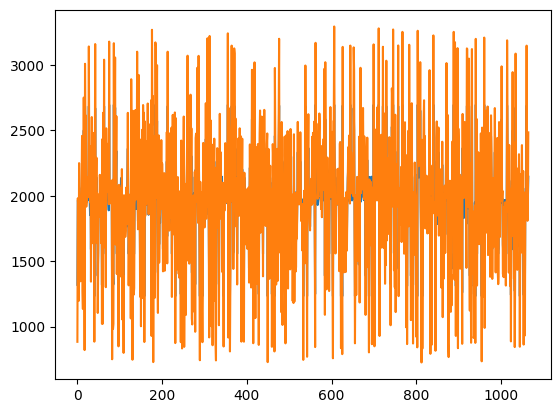

In [21]:
plt.plot(pd.Series(pred).apply(lambda x: (x * mean_var['kospi'][1]) + mean_var['kospi'][0]).values)
plt.plot(test_y.apply(lambda x: (x * mean_var['kospi'][1]) + mean_var['kospi'][0]).values)
plt.show()

In [22]:
test_result = pd.DataFrame([test_y.apply(lambda x: (x * mean_var['kospi'][1]) + mean_var['kospi'][0]).values, 
                            pd.Series(pred).apply(lambda x: (x * mean_var['kospi'][1]) + mean_var['kospi'][0]).values]).transpose()
test_result.columns = ['y', 'pred']
test_result['diff'] = test_result['y'] - test_result['pred']
test_result

,y,pred,diff
0,884.289978,1319.370755,-435.080777
1,1980.829956,1964.017984,16.811972
2,1917.640015,1964.017984,-46.377969
3,1196.670044,1473.947712,-277.277668
4,2249.370117,2063.132408,186.237709
...,...,...,...
1060,3146.810059,2689.534651,457.275408
1061,2019.530029,1949.033511,70.496518
1062,1808.619995,1949.033511,-140.413516
1063,1959.439941,1974.917843,-15.477902


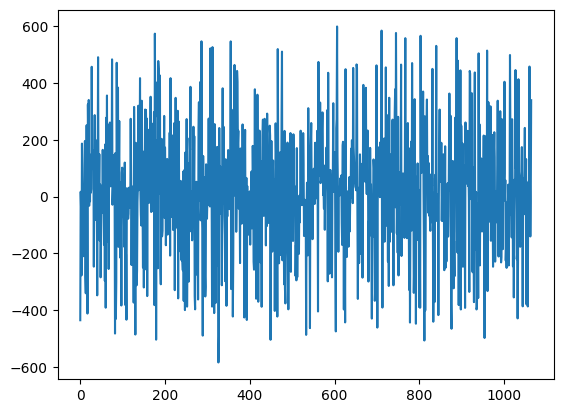

In [23]:
plt.plot(test_result['diff'])
plt.show()

In [24]:
# np.sqrt(test_result['diff'].sum())
print(np.sqrt((test_result['diff']**2).sum())/len(test_result))
np.sqrt((test_result['diff']**2).sum())

6.5217285694326375


6945.640926445759

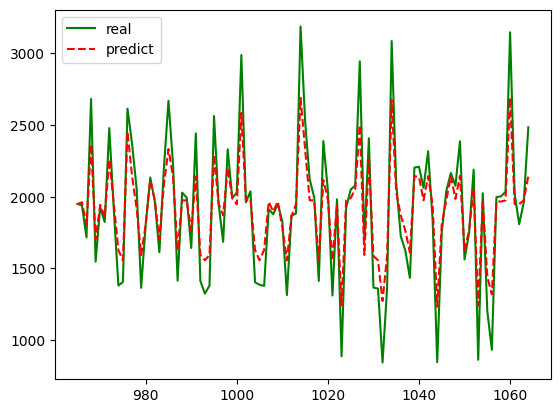

In [25]:
plt.plot(test_result['y'][-100:], 'g-', label='real')
plt.plot(test_result['pred'][-100:], 'r--', label='predict')
plt.legend()
plt.show()